## Setting up Colab

Checking the GPU that is provided by Colab

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-60d7c1a9-fa6c-28ee-f561-58bd7fbdfa16)


Mounting my drive to access the datasets

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/wotr_colab")

Mounted at /content/drive


## Importing Libraries

In [ ]:
import os
from sklearn import metrics
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Loading Datasets

I have used the following datasets - 
1. PlantVillage ([Source]())
2. PlantDoc ([Source 1](), [Source 2]())

In order to reproduce, download all the folders [here](https://drive.google.com/drive/folders/1FbT5aFvC7Ve0lr8iHKUvE8teqKAnuefZ?usp=sharing) and store in working directory


## Model 1 and Model 2

### Preparing Data
Code in below cell was borrowed from my prior work. The source notebooks are linked in the README

In [ ]:
def load_dataset(data_path: str, data_augment=False):
    data_path = data_path
    transforms_ = [transforms.Resize((64, 64))]
    transforms_aug = [transforms.RandomHorizontalFlip(p=0.5),
                      transforms.RandomRotation(25),
                      transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0))] + transforms_
                  
    transformations = transforms_aug if data_augment else transforms_
    
    dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transforms.Compose(transformations+[transforms.ToTensor(),
                                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

    return dataset

def prepare_data(dataset, batch_size=32):
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=1,
        shuffle=True
    )

    return data_loader


train_df = load_dataset("cropped_plantdoc/TRAIN", data_augment=True)
test_df = load_dataset("cropped_plantdoc/TEST")
pvd_train = load_dataset("pvd_subset_train")
pvd_test = load_dataset("pvd_subset_test")

assert train_df.class_to_idx==test_df.class_to_idx==pvd_train.class_to_idx==pvd_test.class_to_idx, "Class Indexes Mismatch"

train_ldr = prepare_data(train_df)
test_ldr = prepare_data(test_df)
pvtrain_ldr = prepare_data(pvd_train)
pvtest_ldr = prepare_data(pvd_test)


### Visualizing Sample Images (PlantVillage and Cropped PlantDoc datasets)




In [ ]:
trainiter = iter(train_ldr)
pd_trX, pd_try = next(trainiter)

testiter = iter(test_ldr)
pd_tsX, pd_tsy = next(testiter)

pvtr_iter = iter(pvtrain_ldr)
pv_trX, pv_try = next(pvtr_iter)

pvts_iter = iter(pvtest_ldr)
pv_tsX, pv_tsy = next(pvts_iter)

Text(0.5, 1.0, 'Tomato leaf yellow virus(from PlantVillage Test)')

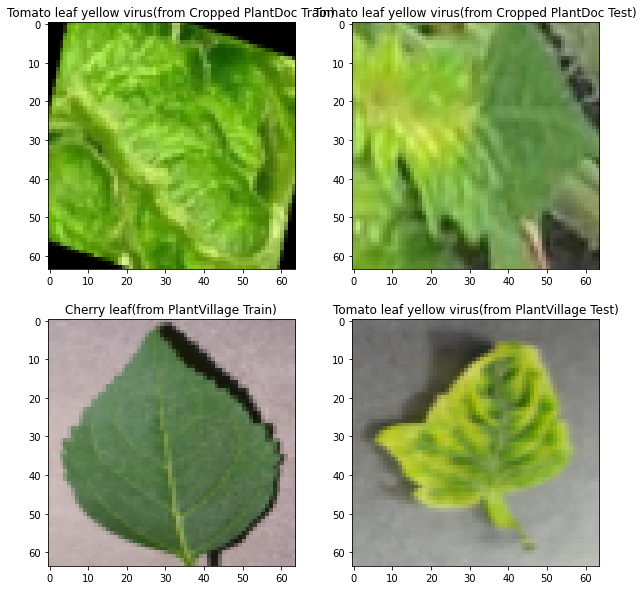

In [ ]:
ix=0
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(pd_trX[ix].permute(1,2,0)*0.5 + 0.5)
plt.title(train_df.classes[pd_try[ix].item()] + "(from Cropped PlantDoc Train)")
plt.subplot(2,2,2)
plt.imshow(pd_tsX[ix].permute(1,2,0)*0.5 + 0.5)
plt.title(train_df.classes[pd_tsy[ix].item()] + "(from Cropped PlantDoc Test)")

plt.subplot(2,2,3)
plt.imshow(pv_trX[ix].permute(1,2,0)*0.5 + 0.5)
plt.title(train_df.classes[pv_try[ix].item()] + "(from PlantVillage Train)")
plt.subplot(2,2,4)
plt.imshow(pv_tsX[ix].permute(1,2,0)*0.5 + 0.5)
plt.title(train_df.classes[pv_tsy[ix].item()] + "(from PlantVillage Test)")



### Defining the Model

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5, stride=1)
    self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1)
    self.mp2 = nn.MaxPool2d(kernel_size=3, stride=3)
    
    self.linear1 = nn.Conv2d(in_channels=16, out_channels=512, kernel_size=8)
    self.dropout1 = nn.Dropout()
    self.linear2 = nn.Conv2d(in_channels=512, out_channels=64, kernel_size=1)
    self.dropout2 = nn.Dropout()
    self.linear3 = nn.Conv2d(in_channels=64, out_channels=29, kernel_size=1)
  
  def forward(self, x):
    aft_conv1 = F.relu(self.conv1(x))
    aft_conv2 = F.relu(self.conv2(aft_conv1))
    aft_mp1 = self.mp1(aft_conv2)
    aft_conv3 = F.relu(self.conv3(aft_mp1))
    aft_mp2 = self.mp2(aft_conv3)

    aft_lnr1 = self.dropout1(F.relu(self.linear1(aft_mp2)))
    aft_lnr2 = self.dropout2(F.relu(self.linear2(aft_lnr1)))
    aft_lnr3 = self.linear3(aft_lnr2)
    return aft_lnr3.squeeze()
    

### Training Loop
The training loop code was borrowed from my prior work. The source notebooks are linked in the README

In [ ]:
model = CNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#### Model 1 Training

In [ ]:
import time
t = []
n_batches_tr = len(pvtrain_ldr)
ep_acc = []
test_acc = 0
for epoch in range(200):  # loop over the dataset multiple times
    ep_acc.append(test_acc)
    acc = []
    tic = time.time()
    for i, data in enumerate(pvtrain_ldr, 0):    #trying training on plantvillage and testing on c-pd now
        # get the inputs; data is a list of [inputs, labels]
        model.train()
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i%10==9 and i<n_batches_tr-1:
          model.eval()
          test_sample = next(iter(pvtest_ldr))
          if len(test_sample[1])!=32:
            continue
          test_X_pv, test_y_pv = test_sample[0].to(device), test_sample[1].to(device)
          with torch.no_grad():
            test_out = model(test_X_pv)
            test_out = test_out.argmax(dim=1)
            test_acc = metrics.accuracy_score(test_y_pv.cpu(), test_out.cpu())
            acc.append(test_acc)
            print(f"Test accuracy PD estimate after {epoch+1} epochs, {i+1} batches: {str(test_acc)}")
    print("epoch done: changing model state to eval")
    model.eval()
    with torch.no_grad():
      test_acc = np.mean(acc)
      if test_acc>max(ep_acc):# and epoch>1:
        torch.save(model.state_dict(), f"models/customCNN_sw_pvd_{int(round(test_acc*100))}.pth")
      print(f"Test accuracy est. on PD in epoch {epoch+1}: {str(test_acc)}")
    toc = time.time()
    t.append(toc-tic)

print('Finished Training')

#### Model 2 Training

In [ ]:
model.load_state_dict(torch.load("models/customCNN_sw_pvd_94.pth"))

<All keys matched successfully>

In [ ]:
import time
t = []
n_batches_tr = len(train_ldr)
ep_acc = []
test_acc = 0
for epoch in range(200):  # loop over the dataset multiple times
    ep_acc.append(test_acc)
    acc = []
    tic = time.time()
    for i, data in enumerate(train_ldr, 0):    #trying training on plantvillage and testing on c-pd now
        # get the inputs; data is a list of [inputs, labels]
        model.train()
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i%10==9 and i<n_batches_tr-1:
          model.eval()
          test_sample = next(iter(test_ldr))
          if len(test_sample[1])!=32:
            continue
          test_X_pv, test_y_pv = test_sample[0].to(device), test_sample[1].to(device)
          with torch.no_grad():
            test_out = model(test_X_pv)
            test_out = test_out.argmax(dim=1)
            test_acc = metrics.accuracy_score(test_y_pv.cpu(), test_out.cpu())
            acc.append(test_acc)
            print(f"Test accuracy PD estimate after {epoch+1} epochs, {i+1} batches: {str(test_acc)}")
    model.eval()
    with torch.no_grad():
      test_acc = np.mean(acc)
      if test_acc>max(ep_acc) and epoch>1:
        torch.save(model.state_dict(), f"models/customCNN_sw_pvd_and_cpd_{int(round(test_acc*100))}.pth")
      print(f"Test accuracy est. on PD in epoch {epoch+1}: {str(test_acc)}")
    toc = time.time()
    t.append(toc-tic)

print('Finished Training')

In [ ]:
model.load_state_dict(torch.load("models/customCNN_sw_pvd_and_cpd_30.pth"))

<All keys matched successfully>

### Evaluation

In [ ]:
def evaluate(model, test_ldr):
  total_correct = 0
  model.eval()
  for data in test_ldr:
    X, y = data[0].to(device), data[1].to(device)
    with torch.no_grad():
      yhat = model(X)
    n_correct = torch.sum(torch.argmax(yhat, dim=1) == y)
    total_correct += n_correct.item()
  return total_correct/len(test_ldr)

pd_test = load_dataset("PlantDoc-Dataset/test")
pd_ts_ldr = prepare_data(pd_test)

model.load_state_dict(torch.load("models/customCNN_sw_pvd_94.pth"))
acc_pvd = evaluate(model, pvtest_ldr)
acc_cpd = evaluate(model, test_ldr)
acc_pd = evaluate(model, pd_ts_ldr)


print(f"Model 1 acc on PV: {acc_pvd}")
print(f"Model 1 acc on C-PD: {acc_cpd}")
print(f"Model 1 acc on PD: {acc_pd}")


model.load_state_dict(torch.load("models/customCNN_sw_pvd_and_cpd_31.pth"))
acc_pvd = evaluate(model, pvtest_ldr)
acc_cpd = evaluate(model, test_ldr)
acc_pd = evaluate(model, pd_ts_ldr)

print(f"Model 2 acc on PV: {acc_pvd}")
print(f"Model 2 acc on C-PD: {acc_cpd}")
print(f"Model 2 acc on PD: {acc_pd}")


## Model 3

### Defining the Model

In Model 3, Sliding Window approach is implemented. It allows getting predictions of Model 2 on different cropped rectangular regions of the image at no extra computational cost (by simply feeding a larger image to the model.  It is commonly used for Object Detection. But here, I try to use it for classification. I add two dense layers at the end to give final prediction based on Model 2's predictions on cropped regions. The idea is that Model 2's predictions on cropped regions may be more valuable instead of its prediction on the entire image.

Instead of simply inputting a larger sized image to Model 2, two images are inputted. One is of size 256x256 and the other of size 520x520. This gives Model 2 predictions on cropped regions of two sizes. After getting Model 2 predictions, max pooling is applied to compress the data, before adding the two dense layers.

In [ ]:
class CNN2(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn = CNN()
    self.cnn.load_state_dict(torch.load("models/customCNN_sw_pvd_and_cpd_30.pth"))
    
    self.linear1 = nn.Linear(in_features=7018, out_features=200)
    self.dropout1 = nn.Dropout()
    self.linear2 = nn.Linear(in_features=200, out_features=29)
  
  def forward(self, x1, x2):
    out1 = F.softmax(self.cnn(x1), dim=1) #input image 3x256x256 -> output 29x33x33
    out1 = F.max_pool2d(input=out1, kernel_size=3, stride=3)
    out1 = torch.reshape(out1, (-1, 3509))

    out2 = F.softmax(self.cnn(x2), dim=1) #input image 3x520x520 -> output 29x77x77
    out2 = F.max_pool2d(input=out2, kernel_size=7, stride=7)
    out2 = torch.reshape(out2, (-1, 3509))

    cnn_out = torch.cat([out1, out2], dim=1)
    assert cnn_out.size()[1] == 7018, f"output is {cnn_out.size()}"

    aft_lnr1 = self.dropout1(F.relu(self.linear1(cnn_out)))
    aft_lnr2 = self.linear2(aft_lnr1)
    return aft_lnr2


### Preparing Data Loader to Input Two Images
The script in below cell was borrowed from [here](https://discuss.pytorch.org/t/make-imagefolder-output-the-same-image-twice-with-different-transforms/21887/5)

In [ ]:
import torch.utils.data as data

from PIL import Image
import os
import os.path

IMG_EXTENSIONS = [
   '.jpg', '.JPG', '.jpeg', '.JPEG',
   '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def is_image_file(filename):
   return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def find_classes(dir):
   classes = os.listdir(dir)
   classes.sort()
   class_to_idx = {classes[i]: i for i in range(len(classes))}
   return classes, class_to_idx


def make_dataset(dir, class_to_idx):
   images = []
   for target in os.listdir(dir):
       d = os.path.join(dir, target)
       if not os.path.isdir(d):
           continue

       for filename in os.listdir(d):
           if is_image_file(filename):
               path = '{0}/{1}'.format(target, filename)
               item = (path, class_to_idx[target])
               images.append(item)

   return images


def default_loader(path):
   return Image.open(path).convert('RGB')


class ImageFolderLoader(data.Dataset):
   def __init__(self, root, transform_1=None,
                transform_2=None, target_transform=None,
                loader=default_loader):
       classes, class_to_idx = find_classes(root)
       imgs = make_dataset(root, class_to_idx)

       self.root = root
       self.imgs = imgs
       self.classes = classes
       self.class_to_idx = class_to_idx
       self.transform_1 = transform_1
       self.transform_2 = transform_2
       self.target_transform = target_transform
       self.loader = loader

   def __getitem__(self, index):
       path, target = self.imgs[index]
       img = self.loader(os.path.join(self.root, path))
       if self.transform_1 is not None:
           img1 = self.transform_1(img)
       if self.transform_2 is not None:
           img2 = self.transform_2(img)
       if self.target_transform is not None:
           target = self.target_transform(target)

       return img1, img2, target

   def __len__(self):
       return len(self.imgs)

       
transforms1 = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                      transforms.RandomRotation(25),
                      transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                      transforms.Resize((256, 256)),
                      transforms.ToTensor(),
                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

transforms2 = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                      transforms.RandomRotation(25),
                      transforms.RandomResizedCrop(size=520, scale=(0.8, 1.0)),
                      transforms.Resize((520, 520)),
                      transforms.ToTensor(),
                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

tr_dt = ImageFolderLoader(
        "PlantDoc-Dataset/train",
        transform_1=transforms1,
        transform_2=transforms2
    )

ts_dt = ImageFolderLoader(
        "PlantDoc-Dataset/test",
        transform_1=transforms1,
        transform_2=transforms2
    )

assert tr_dt.classes == ts_dt.classes

tr_ldr = torch.utils.data.DataLoader(
        tr_dt, batch_size=32,
        shuffle=True, num_workers=16
  )

ts_ldr = torch.utils.data.DataLoader(
        ts_dt, batch_size=32,
        shuffle=True, num_workers=16, 
  )

### Visualizing Sample Images (PlantDoc Dataset)

In [ ]:
trainiter = iter(tr_ldr)
testiter = iter(ts_ldr)

In [ ]:
tr_sample = next(trainiter)
ts_sample = next(testiter)

Text(0.5, 1.0, 'Cherry leaf 512x512')

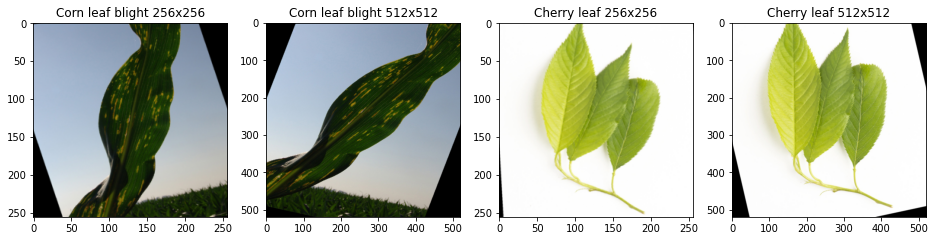

In [ ]:
ix = 0
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(tr_sample[0][ix].permute(1,2,0)*0.5 + 0.5)
plt.title(tr_dt.classes[tr_sample[2][ix].item()] + " 256x256")
plt.subplot(1,4,2)
plt.imshow(tr_sample[1][ix].permute(1,2,0)*0.5 + 0.5)
plt.title(tr_dt.classes[tr_sample[2][ix].item()] + " 512x512")

plt.subplot(1,4,3)
plt.imshow(ts_sample[0][ix].permute(1,2,0)*0.5 + 0.5)
plt.title(tr_dt.classes[ts_sample[2][ix].item()] + " 256x256")
plt.subplot(1,4,4)
plt.imshow(ts_sample[1][ix].permute(1,2,0)*0.5 + 0.5)
plt.title(tr_dt.classes[ts_sample[2][ix].item()] + " 512x512")


### Model 3 Training
The training loop code was borrowed from my prior work. The source notebooks are linked in the README

In [ ]:
model2 = CNN2()
model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for i, param in enumerate(model2.parameters()):
    print(i, param.size())
    if i<12:
      param.requires_grad = False

0 torch.Size([32, 3, 5, 5])
1 torch.Size([32])
2 torch.Size([16, 32, 5, 5])
3 torch.Size([16])
4 torch.Size([16, 16, 5, 5])
5 torch.Size([16])
6 torch.Size([512, 16, 8, 8])
7 torch.Size([512])
8 torch.Size([64, 512, 1, 1])
9 torch.Size([64])
10 torch.Size([29, 64, 1, 1])
11 torch.Size([29])
12 torch.Size([200, 7018])
13 torch.Size([200])
14 torch.Size([29, 200])
15 torch.Size([29])


In [ ]:
import time
t = []
ep_acc = []
test_acc = 0
n_batches_tr = len(tr_ldr)
for epoch in range(200):  # loop over the dataset multiple times
    ep_acc.append(test_acc)
    acc = []
    tic = time.time()
    for i, data in enumerate(tr_ldr, 0):    #trying training on plantvillage and testing on c-pd now
        # get the inputs; data is a list of [inputs, labels]
        model2.train()
        input1, input2, labels = data[0].to(device), data[1].to(device), data[2].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model2(input1, input2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i%10==9 and i<n_batches_tr-1:
          model2.eval()
          test_sample = next(iter(ts_ldr))
          if len(test_sample[1])!=32:
            continue
          test_X1, test_X2, test_y = test_sample[0].to(device), test_sample[1].to(device), test_sample[2].to(device)
          with torch.no_grad():
            test_out = model2(test_X1, test_X2)
            test_out = test_out.argmax(dim=1)
            test_acc = metrics.accuracy_score(test_y.cpu(), test_out.cpu())
            acc.append(test_acc)
            print(f"Test accuracy estimate after {epoch+1} epochs, {i+1} batches: {str(test_acc)}")
    model2.eval()
    with torch.no_grad():
      test_acc = np.mean(acc)
      if test_acc>max(ep_acc) and epoch>1:
        torch.save(model2.state_dict(), f"models/customCNN2_{int(round(test_acc*100))}.pth")
      print(f"Test accuracy est. on in epoch {epoch+1}: {str(test_acc)}")
    toc = time.time()
    t.append(toc-tic)

print('Finished Training')

In [ ]:
model2.load_state_dict(torch.load("models/customCNN2_20.pth"))

<All keys matched successfully>

In [ ]:
for i, param in enumerate(model2.parameters()):
      param.requires_grad = True

In [ ]:
import time
t = []
ep_acc = []
test_acc = 0
n_batches_tr = len(tr_ldr)
for epoch in range(200):  # loop over the dataset multiple times
    ep_acc.append(test_acc)
    acc = []
    tic = time.time()
    for i, data in enumerate(tr_ldr, 0):    #trying training on plantvillage and testing on c-pd now
        # get the inputs; data is a list of [inputs, labels]
        model2.train()
        input1, input2, labels = data[0].to(device), data[1].to(device), data[2].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model2(input1, input2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i%10==9 and i<n_batches_tr-1:
          model2.eval()
          test_sample = next(iter(ts_ldr))
          if len(test_sample[1])!=32:
            continue
          test_X1, test_X2, test_y = test_sample[0].to(device), test_sample[1].to(device), test_sample[2].to(device)
          with torch.no_grad():
            test_out = model2(test_X1, test_X2)
            test_out = test_out.argmax(dim=1)
            test_acc = metrics.accuracy_score(test_y.cpu(), test_out.cpu())
            acc.append(test_acc)
            print(f"Test accuracy estimate after {epoch+1} epochs, {i+1} batches: {str(test_acc)}")
    model2.eval()
    with torch.no_grad():
      test_acc = np.mean(acc)
      if test_acc>max(ep_acc) and epoch>1:
        torch.save(model2.state_dict(), f"models/customCNN2_{int(round(test_acc*100))}.pth")
      print(f"Test accuracy est. on in epoch {epoch+1}: {str(test_acc)}")
    toc = time.time()
    t.append(toc-tic)

print('Finished Training')

### Evaluation

In [ ]:
def evaluate2(model=model2, test_ldr):
  total_correct = 0
  model.eval()
  for data in test_ldr:
    X1, X2, y = data[0].to(device), data[1].to(device), data[2].to(device)
    with torch.no_grad():
      yhat = model(X1, X2)
    n_correct = torch.sum(torch.argmax(yhat, dim=1) == y)
    total_correct += n_correct.item()
  return total_correct/len(test_ldr)

model2.load_state_dict(torch.load("models/customCNN2_27.pth"))
acc_pvd = evaluate2(model2, pvtest_ldr)
acc_cpd = evaluate2(model2, test_ldr)
acc_pd = evaluate2(model2, ts_ldr)

print(f"Model 3 acc on PV: {acc_pvd}")
print(f"Model 3 acc on C-PD: {acc_cpd}")
print(f"Model 3 acc on PD: {acc_pd}")